# German Credit Dataset Analysis
This notebook performs preprocessing, analysis, and visualization tasks.

## Preprocessing

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("GermanCredit.csv")

# Drop columns with highest counts of 'none'
def drop_top_none_cols(df, n=3):
    none_counts = []
    for col in df.columns:
        count_none = (df[col] == "none").sum()
        none_counts.append((col, count_none))
    col_order = {col: i for i, col in enumerate(df.columns)}
    none_counts.sort(key=lambda x: (-x[1], col_order[x[0]]))
    cols_to_drop = [col for col, _ in none_counts[:n]]
    df = df.drop(columns=cols_to_drop)
    return df

df = drop_top_none_cols(df, 3)

# Remove apostrophes
df = df.map(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Map checking_status
checking_map = {
    "no checking": "No Checking",
    "<0": "Low",
    "0<=X<200": "Medium",
    ">=200": "High"
}
df["checking_status"] = df["checking_status"].map(checking_map)

# Map savings_status
savings_map = {
    "no known savings": "No Savings",
    "<100": "Low",
    "100<=X<500": "Medium",
    "500<=X<1000": "High",
    ">=1000": "High"
}
df["savings_status"] = df["savings_status"].map(savings_map)

# Map class
df["class"] = df["class"].map({"good": 1, "bad": 0})

# Map employment
employment_map = {
    "unemployed": "Unemployed",
    "<1": "Amateur",
    "1<=X<4": "Professional",
    "4<=X<7": "Experienced",
    ">=7": "Expert"
}
df["employment"] = df["employment"].map(employment_map)

df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,residence_since,property_magnitude,age,housing,existing_credits,job,num_dependents,foreign_worker,class
0,Low,6,critical/other existing credit,radio/tv,1169,No Savings,Expert,4,male single,4,real estate,67,own,2,skilled,1,yes,1
1,Medium,48,existing paid,radio/tv,5951,Low,Professional,2,female div/dep/mar,2,real estate,22,own,1,skilled,1,yes,0
2,No Checking,12,critical/other existing credit,education,2096,Low,Experienced,2,male single,3,real estate,49,own,1,unskilled resident,2,yes,1
3,Low,42,existing paid,furniture/equipment,7882,Low,Experienced,2,male single,4,life insurance,45,for free,1,skilled,2,yes,1
4,Low,24,delayed previously,new car,4870,Low,Professional,3,male single,4,no known property,53,for free,2,skilled,2,yes,0


## Analysis

In [12]:
# Crosstab foreign_worker vs class
foreign_vs_class = pd.crosstab(df["foreign_worker"], df["class"])
foreign_vs_class

class,0,1
foreign_worker,,
no,4,33
yes,296,667


In [13]:
# Crosstab employment vs savings_status
employment_vs_savings = pd.crosstab(df["employment"], df["savings_status"])
employment_vs_savings

savings_status,High,Low,Medium,No Savings
employment,,,,
Amateur,12,120,17,23
Experienced,18,100,24,32
Expert,34,133,22,64
Professional,44,210,33,52
Unemployed,3,40,7,12


In [14]:
# Average credit amount of single males with 4<=X<7 yrs employment
single_male = df["personal_status"] == "male single"
experienced = df["employment"] == "Experienced"
df.loc[single_male & experienced, "credit_amount"].mean()

4142.592592592592

In [15]:
# Average credit duration for each job type
df.groupby("job")["duration"].mean()

job
high qualif/self emp/mgmt    25.168919
skilled                      21.411111
unemp/unskilled non res      17.363636
unskilled resident           16.535000
Name: duration, dtype: float64

In [16]:
# Most common checking and savings status for purpose 'education'
edu = df[df["purpose"] == "education"]
most_check = edu["checking_status"].mode()[0]
most_save = edu["savings_status"].mode()[0]
print("Most common checking status:", most_check)
print("Most common savings status:", most_save)

Most common checking status: No Checking
Most common savings status: Low


## Visualization

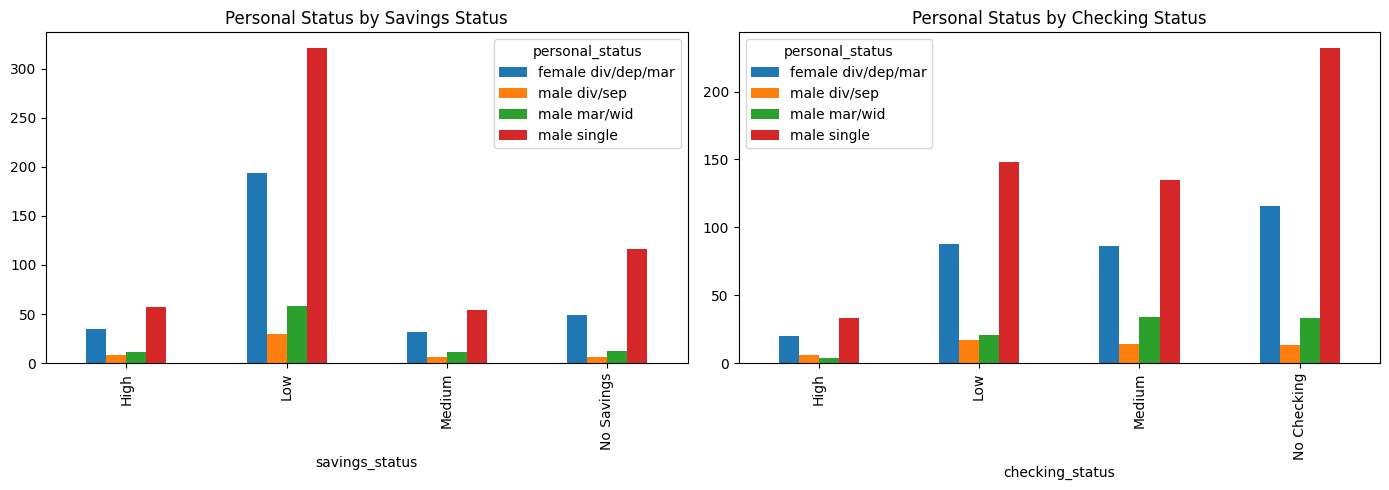

In [17]:
# Bar subplots
personal_savings = pd.crosstab(df["savings_status"], df["personal_status"])
personal_checking = pd.crosstab(df["checking_status"], df["personal_status"])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
personal_savings.plot(kind="bar", ax=axes[0])
axes[0].set_title("Personal Status by Savings Status")

personal_checking.plot(kind="bar", ax=axes[1])
axes[1].set_title("Personal Status by Checking Status")

plt.tight_layout()
plt.show()

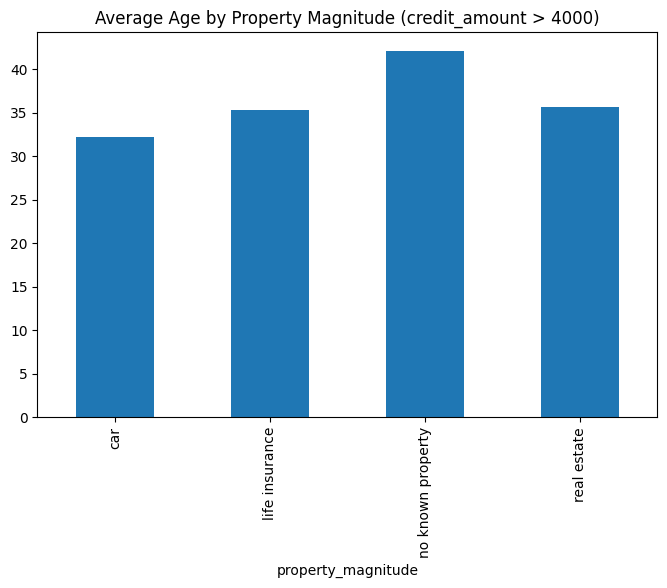

In [18]:
# Age vs property magnitude for credit>4000
high_credit = df[df["credit_amount"] > 4000]
avg_age_by_prop = high_credit.groupby("property_magnitude")["age"].mean()

plt.figure(figsize=(8,5))
avg_age_by_prop.plot(kind="bar")
plt.title("Average Age by Property Magnitude (credit_amount > 4000)")
plt.show()

In [ ]:
# Pie charts for High savings and age>40
subset = df[(df["savings_status"] == "High") & (df["age"] > 40)]

fig, axes = plt.subplots(1, 3, figsize=(18,5))
subset["personal_status"].value_counts().plot(kind="pie", autopct="%1.1f%%", ax=axes[0])
axes[0].set_title("Personal Status")

subset["credit_history"].value_counts().plot(kind="pie", autopct="%1.1f%%", ax=axes[1])
axes[1].set_title("Credit History")

subset["job"].value_counts().plot(kind="pie", autopct="%1.1f%%", ax=axes[2])
axes[2].set_title("Job")

plt.tight_layout()
plt.show()